# CI HW1

## General Highlights

In general, these are the steps that I have performed in this homework:
- Segmenting the data into 3 different datasets under different subjects. 
- Process the data to have daily peak counts. The idea is to use history daily peak counts to predict the future daily peak counts. Then the weekly peak counts will be generated from the daily peak. 
- Each dataset is sliced into training (50%), validation (25%) and test dataset (25%) for model selection and validation.
- Variables I have tried out:
    - Weekend indicator
    - Linear trend
    - Log of linear trend

Eventually:
- For 30-sec data, I use a weekend indicator + log trend model
- For 1-min data, I use a weekend indicator + linear trend model
- For 3-min data, I use a log trend variable with the intercept

## Data Preprocessing

>Below shows part of the 30 seconds jump rope data after data preprocessing.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
import statsmodels.formula.api as smf
from datetime import datetime, timedelta
import macros as mac  # self defined functions repository

pd.options.display.latex.repr = True

rope = pd.read_excel("data/HW1 Data.xlsx")
rope = rope.drop(columns=["Name"])
rope = rope.fillna(0)
rope.loc[rope["Weight"] == 1]  # Weight is 1: 4/6-4/24

# Date preprocessing
rope = rope.loc[rope["Weight"] != 1].drop(
    columns=["Weight"])  # remove Weight=1 rows
rope["week_num"] = rope["Timestamp"].dt.week  # add week of year col
rope["weekday"] = rope["Timestamp"].dt.dayofweek  # add weekday col
rope["weekend"] = (
    (rope["weekday"] > 4).astype(float).map({1: "Yes", 0: "No"})
)  # add weekend indicator col
rope["DOY"] = rope["Timestamp"].dt.dayofyear  # add day of year col

# Get max count for each week, by Subject
rope["weekly_max"] = rope.groupby(["Subject", "week_num"])[
    "Count"].transform(max)
# Get max count for each day, by Subject
rope["daily_max"] = rope.groupby(["Subject", "DOY"])["Count"].transform(max)
# Subset rows only when count=daily_max
rope = rope.loc[rope["Count"] == rope["daily_max"]]

# 30 sec data
rope_30 = rope.loc[rope["Subject"] == "30 seconds"].drop(columns=["Subject"])
# 1 min data
rope_1 = rope.loc[rope["Subject"] == "1 minute"].drop(columns=["Subject"])
# 3 min data
rope_3 = rope.loc[rope["Subject"] == "3 minutes"].drop(columns=["Subject"])

rope_30.head(5)

,Timestamp,Count,week_num,weekday,weekend,DOY,weekly_max,daily_max
2,2019-02-11 17:21:46.884,112,7,0,No,42,115,112
11,2019-02-12 16:17:11.849,115,7,1,No,43,115,115
39,2019-02-27 17:41:03.938,117,9,2,No,58,124,117
60,2019-03-03 17:22:26.390,124,9,6,Yes,62,124,124
66,2019-03-04 16:04:09.264,127,10,0,No,63,128,127


## Data Visualization and Outlier Processing

<IPython.core.display.Javascript object>


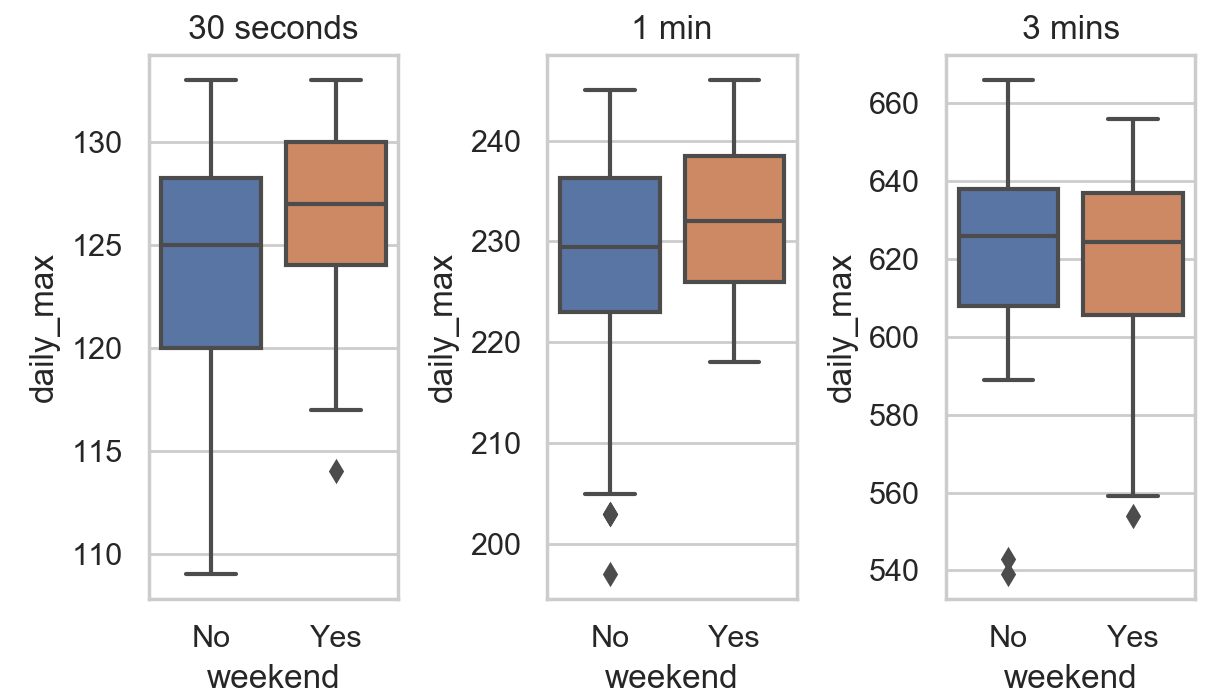

In [27]:
%matplotlib notebook
import seaborn as sns
plt.close("all")
sns.set(style="whitegrid")
plt.subplot(1, 3, 1)
sns.boxplot(x="weekend", y="daily_max", data=rope_30)
plt.title("30 seconds")
plt.subplot(1, 3, 2)
sns.boxplot(x="weekend", y="daily_max", data=rope_1)
plt.title("1 min")
plt.subplot(1, 3, 3)
sns.boxplot(x="weekend", y="daily_max", data=rope_3)
plt.title("3 mins")
plt.show()
plt.tight_layout()

>The above shows the boxplot of daily record at weekdays and weekends. We can tell **there are some level shifts between weekend daily record vs. the weekday's from the above (30 seconds and 1 min).** For the 3-min performances, it is very close in between. We can also see outliers at each plot. 



The below plot show the similar shifts between weekend daily record vs. the weekday's when fitting to a straight line. Here only the 30 secs data is shown. 

<IPython.core.display.Javascript object>


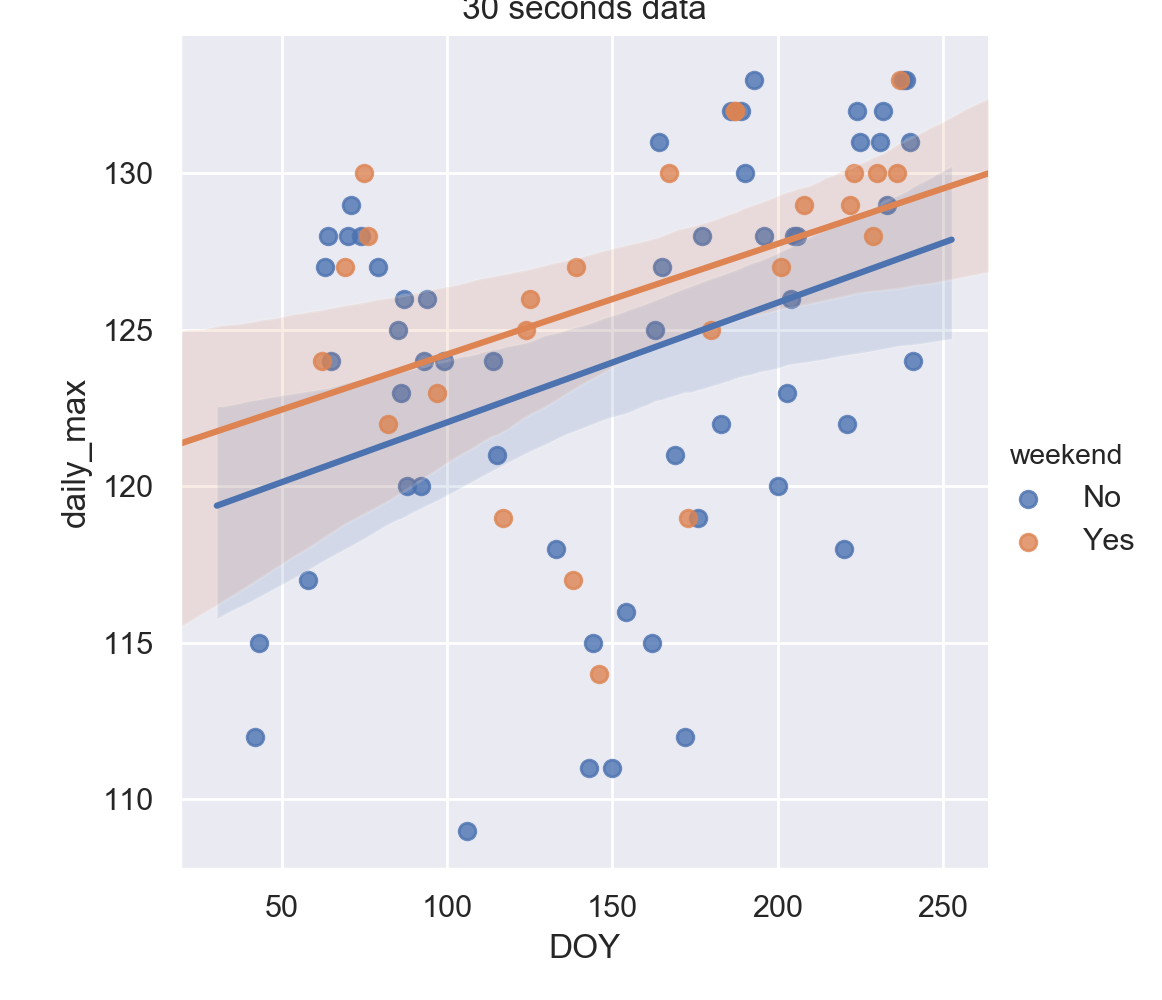

In [28]:
plt.close("all")
sns.set(color_codes=True)
sns.lmplot(x="DOY", y="daily_max", hue='weekend', data=rope_30)
plt.title("30 seconds data")
plt.show()

Next I mark the outliers in the plot. The green dots mark out the data points that are 1 $\sigma$ out from the mean. The red dots mark out the data points that are 2 $\sigma$ out from the mean.

We can see that even after the weight training (4/26, DOY=116, labeled by the red dotted line), the performances are still fairly inconsistent for 30-sec and 1-min subjects. We can also found out: all three data start to stabilize after DOY=175.

<IPython.core.display.Javascript object>


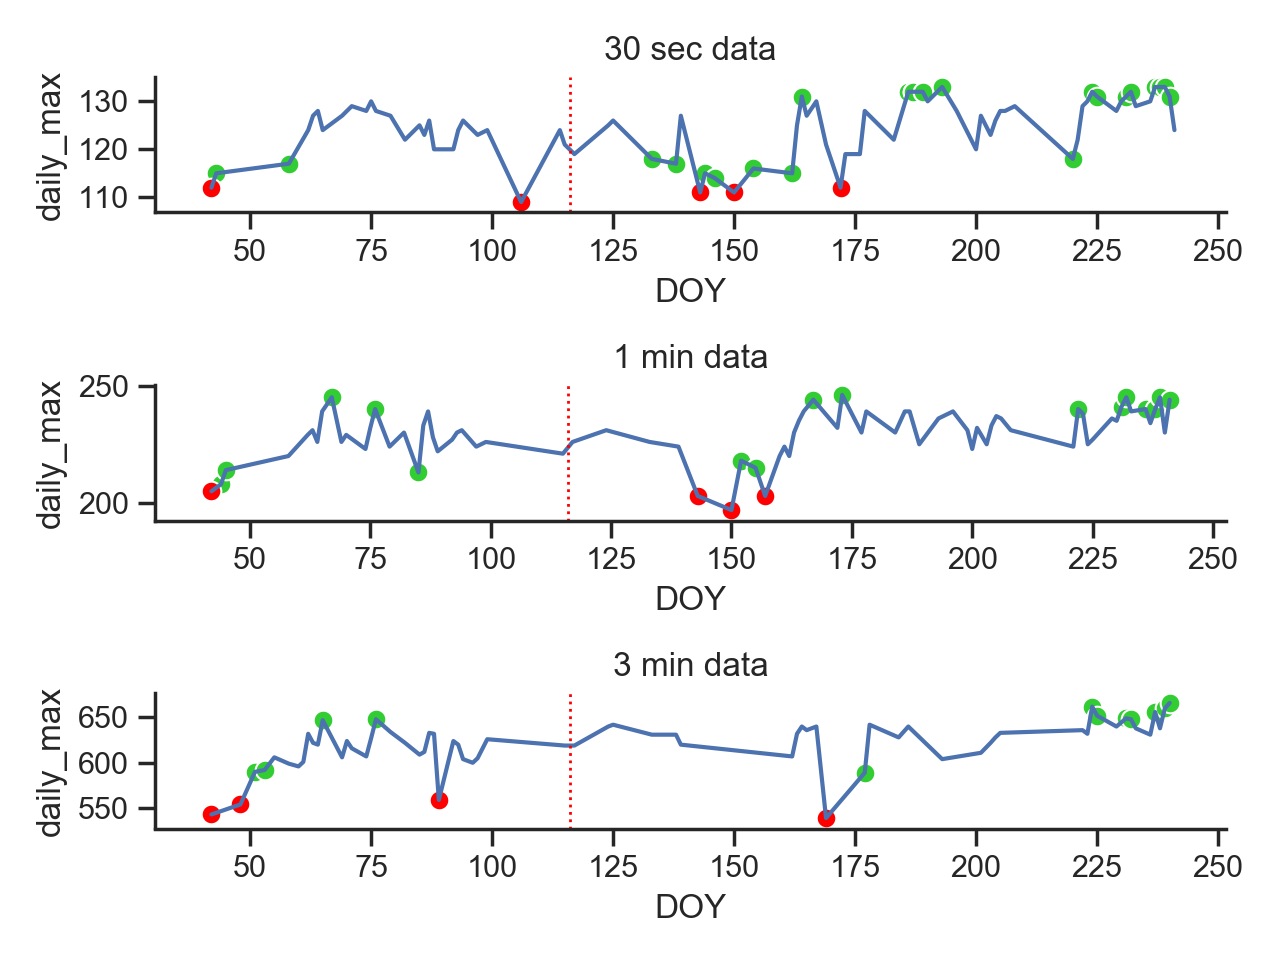

In [30]:
# Define outlier plot function
def outlierplot(df, title):
    std = np.std(df.daily_max)
    dist = np.abs(df.daily_max - np.mean(df.daily_max)) / std
    mask1 = (1 < dist) & (dist <= 2)
    mask2 = dist > 2
    sns.lineplot('DOY', 'daily_max', data=df)
    sns.scatterplot(df.DOY[mask1], df.daily_max[mask1],
                    color='limegreen', marker='o', s=50)
    sns.scatterplot(df.DOY[mask2], df.daily_max[mask2],
                    color='red', marker='o', s=50)
    plt.title(title)
    sns.despine()
    plt.axvline(x=116, color='red', linestyle=':', linewidth=1)

plt.close("all")
sns.set(style="ticks")
plt.subplot(3, 1, 1)
outlierplot(rope_30, '30 sec data')
plt.subplot(3, 1, 2)
outlierplot(rope_1, '1 min data')
plt.subplot(3, 1, 3)
outlierplot(rope_3, '3 min data')
plt.tight_layout()
plt.show()

We need to remove the red dots outliers to a "cleaner" data. Also, we want to focus on the performances after the weight training (4/26, DOY=116). So the data history has been modified to include the DOY>116 only. 

In [31]:
# Remove the outliers
def outlierRemove(df):
    std = np.std(df.daily_max)
    dist = np.abs(df.daily_max - np.mean(df.daily_max)) / std
    mask2 = dist > 2
    df = df[~mask2]
    return df


rope_30 = outlierRemove(rope_30)
rope_1 = outlierRemove(rope_1)
rope_3 = outlierRemove(rope_3)
# Include DOY>116 only.
rope_30 = rope_30.loc[rope_30['DOY'] > 116]
rope_1 = rope_1.loc[rope_1['DOY'] > 116]
rope_3 = rope_3.loc[rope_3['DOY'] > 116]

Continue to analyze on the daily record with respect to the day-of-year:

<IPython.core.display.Javascript object>


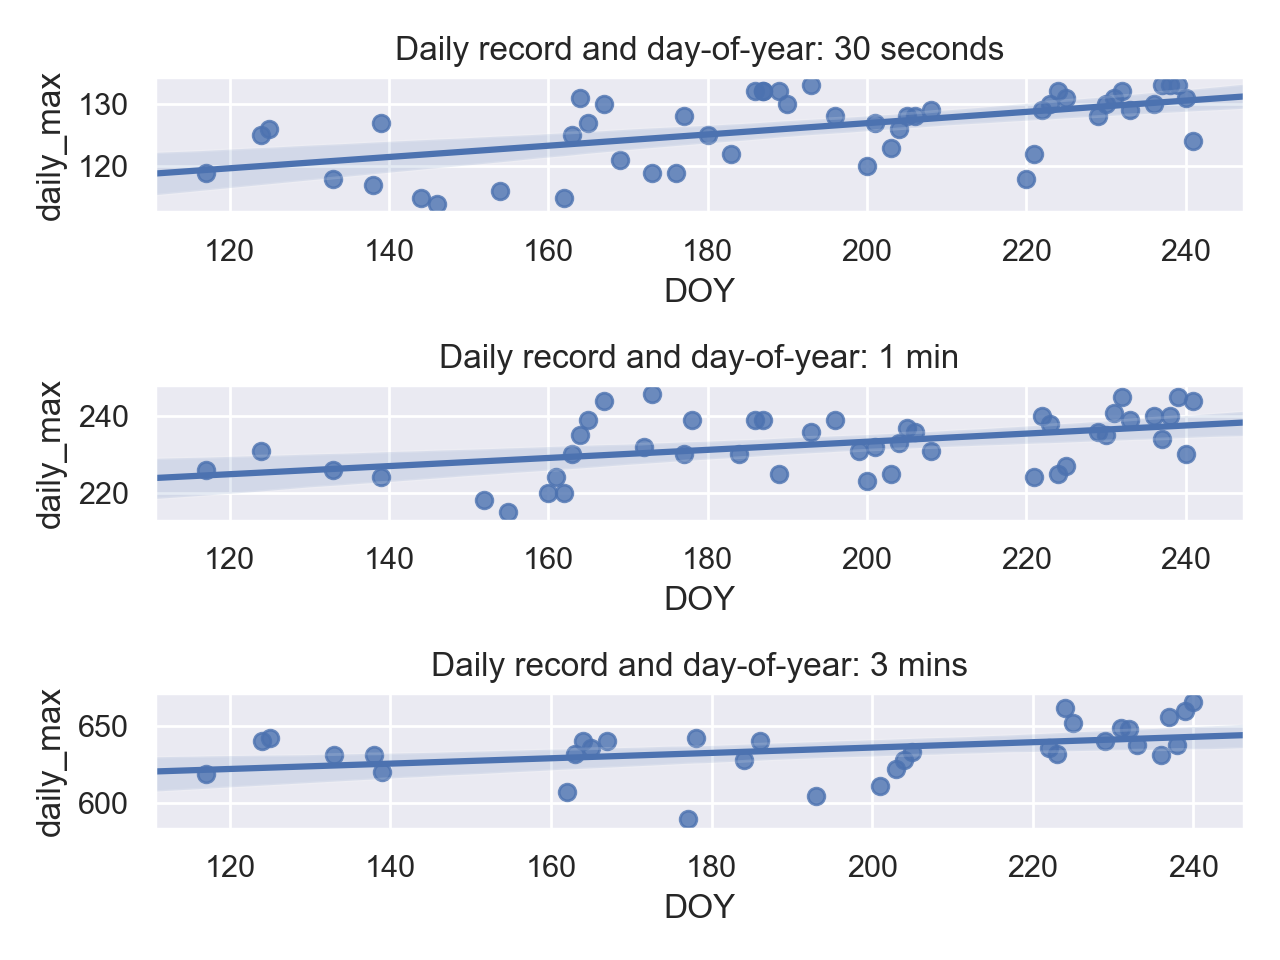

In [32]:
plt.close("all")
sns.set(color_codes=True)
plt.subplot(3, 1, 1)
sns.regplot(x="DOY", y="daily_max", data=rope_30)
plt.title("Daily record and day-of-year: 30 seconds")
plt.subplot(3, 1, 2)
sns.regplot(x="DOY", y="daily_max", data=rope_1)
plt.title("Daily record and day-of-year: 1 min")
plt.subplot(3, 1, 3)
sns.regplot(x="DOY", y="daily_max", data=rope_3)
plt.title("Daily record and day-of-year: 3 mins")
plt.show()
plt.tight_layout()

## Model Build and Selection

From the above the visual analysis, for the modeling part, we can:
* Add a class variable "weekend" when modeling based on 30-second and 1-min data.
* Add a trend variable to depict the growing (linear) trend of daily records for all 3 subjects.

>For all 3 subjects data, the more recent 33% of the data was held out as test set. 

In [33]:
# rope_30 data
import macros as mac  # self defined functions repository

reload(mac)
tr_pct = 2 / 3
val_pct = 1 / 3
test_pct = 0
rope_30 = mac.add_trend(rope_30)  # add trend and logtrend

train, valid, test = (mac.split_df_stat(rope_30, tr_pct, val_pct)[0],
                      mac.split_df_stat(rope_30, tr_pct, val_pct)[1],
                      mac.split_df_stat(rope_30, tr_pct, val_pct)[2])


def trend_test(train, valid):
    """Test if trend variable is good for forecast model."""
    # with linear trend
    res1 = smf.ols(formula='daily_max ~ trend + C(weekend)', data=train).fit()
    pred1 = res1.predict(valid)  # predict on validation set
    # with log trend
    res2 = smf.ols(formula='daily_max ~ logtrend + C(weekend)',
                   data=train).fit()
    pred2 = res2.predict(valid)  # predict on validation set
    # without trend
    res3 = smf.ols(formula='daily_max ~ C(weekend)', data=train).fit()
    pred3 = res3.predict(valid)

    print('MAPE (daily record) with linear trend:',
          mac.mape(valid.daily_max, pred1))
    print('MAPE (daily record) with log trend:',
          mac.mape(valid.daily_max, pred2))
    print('MAPE (daily record) without trend:',
          mac.mape(valid.daily_max, pred3))

    print('MAPE (weekly record) with linear trend:',
          mac.mape(np.max(valid.weekly_max), np.max(pred1)))
    print('MAPE (weekly record) with log trend:', mac.mape(
        np.max(valid.weekly_max), np.max(pred2)))
    print('MAPE (weekly record) without trend:', mac.mape(
        np.max(valid.weekly_max), np.max(pred3)))


trend_test(train=train, valid=valid)

MAPE (daily record) with linear trend: 3.005584416687637
MAPE (daily record) with log trend: 2.4466956261923407
MAPE (daily record) without trend: 4.359633275628888
MAPE (weekly record) with linear trend: 1.7894905671624242
MAPE (weekly record) with log trend: 1.784164010563976
MAPE (weekly record) without trend: 6.188548293811449


>The linear regression model **with log trend variable** results in the best performance on predicting the weekly record, on the 30-sec data. It's performance is very close to the linear trend. 

> Continue onto the 1-min data, the **linear trend model** gives the best overall performance.

In [34]:
# rope_1 data
rope_1 = mac.add_trend(rope_1)  # add trend and logtrend
train, valid, test = (mac.split_df_stat(rope_1, tr_pct, val_pct)[0],
                      mac.split_df_stat(rope_1, tr_pct, val_pct)[1],
                      mac.split_df_stat(rope_1, tr_pct, val_pct)[2])

trend_test(train=train, valid=valid)

MAPE (daily record) with linear trend: 2.025771184308365
MAPE (daily record) with log trend: 2.287050024216825
MAPE (daily record) without trend: 3.259570317242451
MAPE (weekly record) with linear trend: 1.9333519398154821
MAPE (weekly record) with log trend: 2.793330542842297
MAPE (weekly record) without trend: 5.673469387755047


> Continue onto the 3-min data, the model with **only intercept** gives the best overall performance. However in the actual forecast section, I continue to use the **log trend model**, since I think Leo can do better!

In [35]:
# rope_3 data
rope_3 = mac.add_trend(rope_3)  # add trend and logtrend
train, valid, test = (mac.split_df_stat(rope_3, tr_pct, val_pct)[0],
                      mac.split_df_stat(rope_3, tr_pct, val_pct)[1],
                      mac.split_df_stat(rope_3, tr_pct, val_pct)[2])

res1 = smf.ols(formula='daily_max ~ trend', data=train).fit()
pred1 = res1.predict(valid)  # predict on test set
res2 = smf.ols(formula='daily_max ~ logtrend', data=train).fit()
pred2 = res2.predict(valid)  # predict on test set
res3 = smf.ols(formula='daily_max ~ 1', data=train).fit()
pred3 = res3.predict(valid)
print('MAPE (daily record) with linear trend:', mac.mape(valid.daily_max, pred1))
print('MAPE (daily record) with log trend:', mac.mape(valid.daily_max, pred2))
print('MAPE (daily record) without trend:', mac.mape(valid.daily_max, pred3))
print('MAPE (weekly record) with linear trend:', mac.mape(np.max(valid.weekly_max), np.max(pred1)))
print('MAPE (weekly record) with log trend:', mac.mape(np.max(valid.weekly_max), np.max(pred2)))
print('MAPE (weekly record) without trend:', mac.mape(np.max(valid.weekly_max), np.max(pred3)))

MAPE (daily record) with linear trend: 3.7168077394336696
MAPE (daily record) with log trend: 3.5675074403168074
MAPE (daily record) without trend: 3.313499472246729
MAPE (weekly record) with linear trend: 6.068406068406061
MAPE (weekly record) with log trend: 5.999997572600827
MAPE (weekly record) without trend: 5.794430794430816


## Prediction Results

Then I use the selected models for 30 secs, 1 min and 3 mins data to predict the next week (7 days) daily records.

In [36]:
# Predict
# Create forecast set
def forecastset(ip):
    """create forecast dataset from input data set."""
    lasttime = ip['Timestamp'].iloc[-1]  # get last row from Timestamp col
    start = ip['trend'].iloc[-1] + 1 # get last row from trend col
    op = pd.DataFrame(
        {
            # extend the time for 7 days from the last timestamp
            'Timestamp': np.arange(lasttime + timedelta(days=1),
                                   lasttime + timedelta(days=8), timedelta(days=1)).astype(datetime),
            'trend': pd.Series(np.arange(start, start + 7, 1, dtype=int)),
            'logtrend': np.log(pd.Series(np.arange(start, start + 7, 1, dtype=int)))
        }
    )
    op['week_num'] = op['Timestamp'].dt.week
    op['weekday'] = op['Timestamp'].dt.dayofweek  # add weekday col
    op['weekend'] = (op['weekday'] > 4).astype(float).map({1: 'Yes', 0: 'No'})  # add weekend col
    return op


fcst_30 = forecastset(ip=rope_30)  # forecast dataset for 30 secs
fcst_1 = forecastset(ip=rope_1)  # forecast dataset for 1 min
fcst_3 = forecastset(ip=rope_3)  # forecast dataset for 3 mins

For the training data, I purposely (almost arbitrarily) pick the most recent 40 days (DOY>200) as the training set.  

In [37]:
# Fit on data history
rope_30 = rope_30.loc[rope_30['DOY'] > 200]
rope_1 = rope_1.loc[rope_1['DOY'] > 200]
rope_3 = rope_3.loc[rope_3['DOY'] > 200]

# For 30 secs data
res_30 = smf.ols(formula='daily_max ~ logtrend + C(weekend)', data=rope_30).fit()
pred_30 = res_30.predict(fcst_30)  # predict on test set
print('The predicted weekly record for 30 secs jump is:', max(pred_30))

The predicted weekly record for 30 secs jump is: 133.3690873661283


In [38]:
# For 1 min data
res_1 = smf.ols(formula='daily_max ~ trend + C(weekend)', data=rope_1).fit()
pred_1 = res_1.predict(fcst_1)  # predict on test set
print('The predicted weekly record for 1 min jump is:', max(pred_1))

The predicted weekly record for 1 min jump is: 243.83561083381065


In [39]:
# For 3 min data
res_3 = smf.ols(formula='daily_max ~ logtrend', data=rope_3).fit()
pred_3 = res_3.predict(fcst_3)  # predict on test set
print('The predicted weekly record for 3 mins jump is:', max(pred_3))

The predicted weekly record for 3 mins jump is: 666.7276968507492


* The predicted weekly record for 30 secs jump is **133.37**. 

* The predicted weekly record for 1 min jump is **243.84**. 

* The predicted weekly record for 3 mins jump is **666.73**. 

>The parameter estimate for 30 secs data:

In [40]:
print(res_30.params)

Intercept            84.878015
C(weekend)[T.Yes]     1.716553
logtrend             11.725923
dtype: float64


>The parameter estimate for 1 min data:

In [41]:
print(res_1.params)

Intercept            215.878979
C(weekend)[T.Yes]      1.492124
trend                  0.517715
dtype: float64


>The parameter estimate for 3 mins data:

In [42]:
print(res_3.params)

Intercept    475.217360
logtrend      51.915586
dtype: float64


## Solve Using CVXPY

Use the Python CVXPY package to solve the linear regression problem in the last Section. 

>For the 30 secs data:

In [43]:
import cvxpy as cp
from patsy import dmatrix


def OLS_solver(df, log):
    # For dummy coding, We can use df=pd.get_dummies(rope_30, drop_first=True) also.
    levels = df.weekend
    categorical = dmatrix("levels", df.weekend)

    # *****************Solver solution******************** #
    if not log:
        X_lp = np.hstack((np.array(categorical[:, 0])[np.newaxis].T,  # categorical[:, 0] intercept, T is transform
                          np.array(categorical[:, 1])[np.newaxis].T,  # categorical[:, 1] weekend indicator
                          np.array(df.trend)[np.newaxis].T))
    else:
        X_lp = np.hstack((np.array(categorical[:, 0])[np.newaxis].T,  # categorical[:, 0] intercept, T is transform
                          np.array(categorical[:, 1])[np.newaxis].T,  # categorical[:, 1] weekend indicator
                          np.array(df.logtrend)[np.newaxis].T))

    y_lp = np.array(df.daily_max, dtype=np.float32)

    # Define and solve the CVXPY problem.
    beta = cp.Variable(X_lp.shape[1])  # return num of cols
    cost = cp.sum_squares(X_lp * beta - y_lp)  # define cost function
    obj = cp.Minimize(cost)  # define objective function
    prob = cp.Problem(obj)
    prob.solve()
    print("status:", prob.status)
    # print("\nThe optimal OLS value is:", prob.value)  # print optimal value
    print("\nThe optimal parameters are:", beta.value[1:X_lp.shape[1]],
          "\nThe Intercept is:", beta.value[0])
    
OLS_solver(rope_30, log=True)

status: optimal

The optimal parameters are: [ 1.71655346 11.72592289] 
The Intercept is: 84.87801457618203


>Continue on the 1 min data:

In [44]:
OLS_solver(rope_1, log=False)

status: optimal

The optimal parameters are: [1.49212421 0.51771541] 
The Intercept is: 215.87897880697167


>Continue on the 3 mins data:

In [45]:
df = rope_3
# *****************Solver solution******************** #
levels = df.weekend
categorical = dmatrix("levels", df.weekend)
X_lp = np.hstack((np.array(categorical[:, 0])[np.newaxis].T,  # categorical[:, 0] intercept
                  np.array(df.logtrend)[np.newaxis].T))

y_lp = np.array(df.daily_max, dtype=np.float32)

# Define and solve the CVXPY problem.
beta = cp.Variable(X_lp.shape[1])  # return num of cols
cost = cp.sum_squares(X_lp * beta - y_lp)  # define cost function
obj = cp.Minimize(cost)  # define objective function
prob = cp.Problem(obj)
prob.solve()
print("status:", prob.status)
# print("\nThe optimal OLS value is:", prob.value)  # print optimal value
print("\nThe optimal parameters are:", beta.value[1:X_lp.shape[1]],
      "\nThe Intercept is:", beta.value[0])

status: optimal

The optimal parameters are: [51.91558567] 
The Intercept is: 475.21735953030833


**Comparing to the previous section, these parameter estimations match perfectly.**